In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
np.random.seed(777)
import time
import keras as keras
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import decode_predictions
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from tensorflow.keras.layers import concatenate, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input as pi_xcep
from tensorflow.keras.applications import Xception
from keras.models import load_model
from numpy import array
from numpy import argmax
from sklearn.metrics import accuracy_score
from  numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from keras.optimizers import Adam,SGD
from keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Concatenate
from keras.layers import BatchNormalization,Dropout
from keras.layers import Lambda
from keras.regularizers import l2
import math
from keras import backend as K
from keras.metrics import categorical_accuracy
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
from keras.models import load_model

In [ ]:
train_dir = '/content/drive/MyDrive/BACHAugment'
test_dir = '/content/drive/MyDrive/BACHtest'

# Define the image size and batch size
image_size = (224, 224)
batch_size = 32

random_seed = np.random.seed(1142)
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= image_size,
    batch_size=batch_size,
    seed = random_seed,
    shuffle=False,
    subset = 'training',
    class_mode='categorical')

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= image_size,
    batch_size=batch_size,
    seed = random_seed,
    shuffle=False,
    subset = 'validation',
    class_mode='categorical')

test_datagen=ImageDataGenerator(rescale=1./255)
test_generator =test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  seed=random_seed,
                                                  shuffle=False,
                                                  class_mode='categorical') # set as training data


Found 3368 images belonging to 4 classes.
Found 840 images belonging to 4 classes.
Found 103 images belonging to 4 classes.


In [ ]:

nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(val_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))
print(nb_train_samples)
print(nb_validation_samples)
print(nb_test_samples)
print(predict_size_train)
print(predict_size_validation)
print(predict_size_test)

3368
840
103
106
27
4


In [ ]:
model_name="Xception"
model = Xception(include_top=False, weights="imagenet",pooling='avg',input_tensor=Input(shape=(224,224,3)))
model.summary()

83683744/83683744 [==============================] - 3s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [ ]:
image_input =model.input
x1 = GlobalAveragePooling2D()(model.get_layer("block4_sepconv1_act").output) #layer_26
x2 = GlobalAveragePooling2D()(model.get_layer("block5_sepconv1_act").output) #layer_36
x3 = GlobalAveragePooling2D()(model.get_layer("block14_sepconv1").output)  #layer_126
out= Concatenate()([x1,x2,x3])
custom_xcep_model = Model(image_input , out)
custom_xcep_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
for layer in custom_xcep_model.layers[:95]:
    layer.trainable = False
custom_xcep_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
extracted_features_dir = '/content/drive/MyDrive/BACH-Results/XceptionDCNN/'

In [ ]:
#Saving features of the training images
bottleneck_features_train = custom_xcep_model.predict(train_generator)#, predict_size_train)
np.save('/content/drive/MyDrive/BACH-Results/XceptionDCNN/'+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

106/106 [==============================] - 1710s 16s/step


In [ ]:
# Saving features of the validation images
bottleneck_features_validation = custom_xcep_model.predict(val_generator)#, predict_size_validation)
np.save('/content/drive/MyDrive/BACH-Results/XceptionDCNN/'+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [ ]:
# Saving features of the test images
bottleneck_features_validation = custom_xcep_model.predict(test_generator) #, predict_size_test)
np.save('/content/drive/MyDrive/BACH-Results/XceptionDCNN/'+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_validation)

4/4 [==============================] - 59s 16s/step


In [ ]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

In [ ]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)

(3368, 2520)
(840, 2520)
(103, 2520)


In [ ]:
train_labels=train_generator.classes
train_labels=train_labels = keras.utils.to_categorical(train_labels, num_classes=4)
validation_labels=val_generator.classes
validation_labels = keras.utils.to_categorical(validation_labels, num_classes=4)
test_labels=test_generator.classes
test_labels=keras.utils.to_categorical(test_labels,num_classes=4)

In [ ]:

model = Sequential()
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax',name= 'output'))

adam_opt2=Adam(lr = 0.001, beta_1=0.6, beta_2=0.8, amsgrad=True)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=1000,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)


Epoch 1/1000
106/106 - 1s - loss: 1.0010 - accuracy: 0.6345 - val_loss: 0.6787 - val_accuracy: 0.7321 - 1s/epoch - 12ms/step
Epoch 2/1000
106/106 - 0s - loss: 0.6342 - accuracy: 0.7631 - val_loss: 0.5565 - val_accuracy: 0.7833 - 379ms/epoch - 4ms/step
Epoch 3/1000
106/106 - 0s - loss: 0.5360 - accuracy: 0.7972 - val_loss: 0.4661 - val_accuracy: 0.8488 - 347ms/epoch - 3ms/step
Epoch 4/1000
106/106 - 0s - loss: 0.4701 - accuracy: 0.8239 - val_loss: 0.4548 - val_accuracy: 0.8310 - 331ms/epoch - 3ms/step
Epoch 5/1000
106/106 - 0s - loss: 0.4373 - accuracy: 0.8337 - val_loss: 0.3855 - val_accuracy: 0.8464 - 343ms/epoch - 3ms/step
Epoch 6/1000
106/106 - 0s - loss: 0.3847 - accuracy: 0.8575 - val_loss: 0.3482 - val_accuracy: 0.8738 - 423ms/epoch - 4ms/step
Epoch 7/1000
106/106 - 0s - loss: 0.3719 - accuracy: 0.8607 - val_loss: 0.3505 - val_accuracy: 0.8679 - 339ms/epoch - 3ms/step
Epoch 8/1000
106/106 - 0s - loss: 0.3520 - accuracy: 0.8732 - val_loss: 0.3028 - val_accuracy: 0.8869 - 445ms/epo

In [ ]:
import pickle

# Save model weights
model.save_weights('/content/drive/MyDrive/BACH-Results/XceptionDCNN/BACH-XceptionDCNN.h5')

# Save training history
with open('/content/drive/MyDrive/BACH-Results/XceptionDCNN/XceptionDCNNtraining_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
import csv

train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Prepare the data to be saved in the CSV file
data = list(zip(train_loss, train_accuracy, val_loss, val_accuracy))

# Define the CSV file path
csv_file_path = '/content/drive/MyDrive/BACH-Results/XceptionDCNN/metrics_history.csv'

# Write the data to the CSV file
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy'])
    writer.writerows(data)

print("Metrics history saved to", csv_file_path)

Metrics history saved to /content/drive/MyDrive/BACH-Results/XceptionDCNN/metrics_history.csv


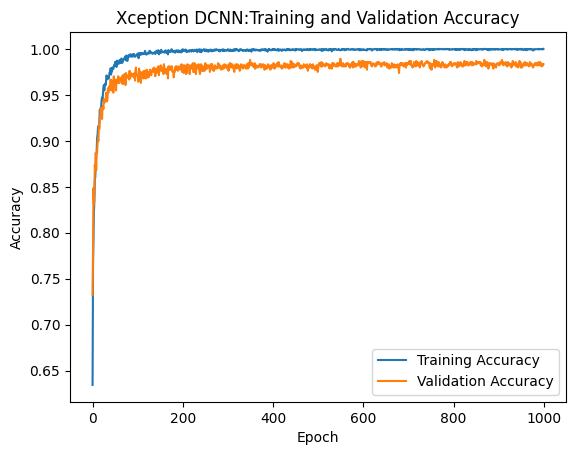

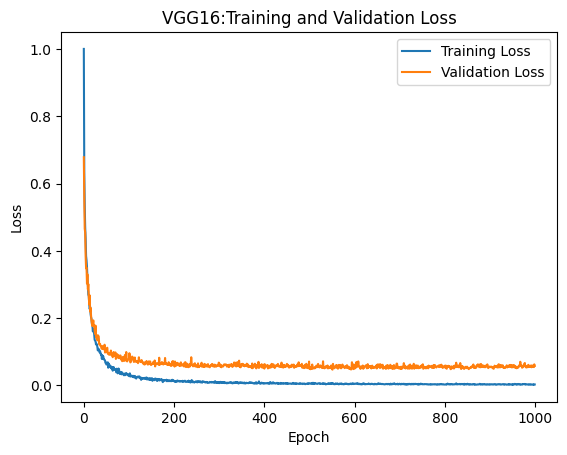

In [ ]:
def plot_curves(history, save_dir):
    # Get training and validation accuracy
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get training and validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create subdirectory for saving plots
    os.makedirs(save_dir, exist_ok=True)

    # Plot training and validation accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Xception DCNN:Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'accuracy.png'))
    plt.show()
    plt.close()

    # Plot training and validation loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('VGG16:Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'loss.png'))
    plt.show()
    plt.close()

plot_curves(history , '/content/drive/MyDrive/BACH-Results/XceptionDCNN')

## Evaluation

In [ ]:
preds = model.predict(validation_data)
predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in validation_labels]
print('Validation Accuracy={}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

27/27 [==============================] - 0s 3ms/step
Validation Accuracy=0.9833333333333333


In [ ]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
#cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Test Accuracy={}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

4/4 [==============================] - 0s 3ms/step
Test Accuracy=0.7475728155339806


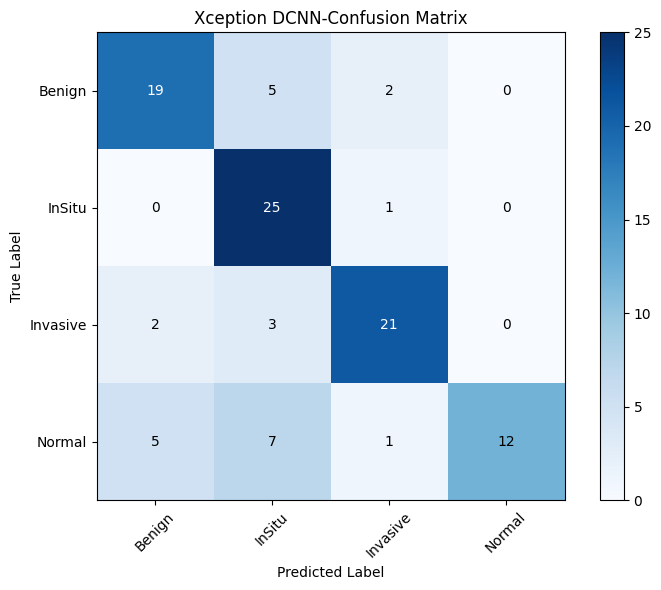

In [ ]:
from sklearn.metrics import confusion_matrix

# Convert predictions into labels (assuming one-hot encoding)
predicted_labels = predictions

# Get the true labels from the test generator
true_labels = y_true

# Get the class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Xception DCNN-Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations in each cell
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/BACH-Results/XceptionDCNN/ConfusionMatrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report as cr
print(cr(true_labels , predicted_labels))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73        26
           1       0.62      0.96      0.76        26
           2       0.84      0.81      0.82        26
           3       1.00      0.48      0.65        25

    accuracy                           0.75       103
   macro avg       0.80      0.74      0.74       103
weighted avg       0.80      0.75      0.74       103



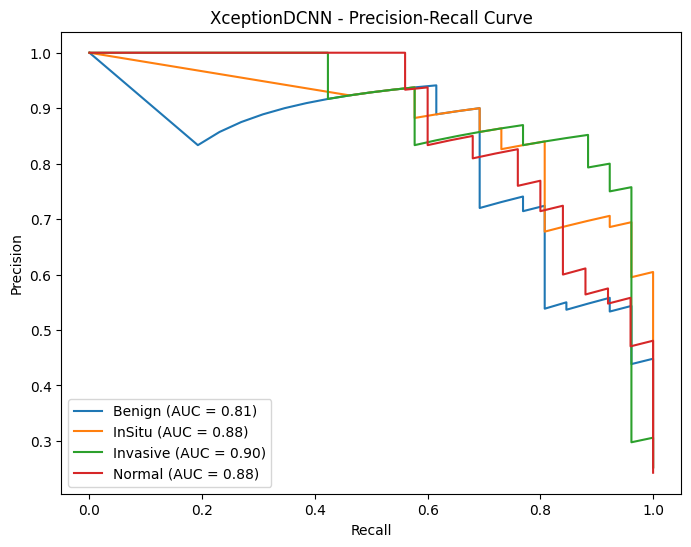

Benign: PR AUC = 0.81
InSitu: PR AUC = 0.88
Invasive: PR AUC = 0.90
Normal: PR AUC = 0.88


In [ ]:
from sklearn.metrics import precision_recall_curve , auc
from tensorflow.keras.utils import to_categorical

def plot_precision_recall_curve(y_true , y_score , class_labels):
    # Compute precision, recall, and thresholds for each class
    precision = dict()
    recall = dict()
    thresholds = dict()
    pr_auc = dict()

    for i, label in enumerate(class_labels):
        precision[label], recall[label], thresholds[label] = precision_recall_curve(
            y_true[:, i], y_score[:, i])
        pr_auc[label] = auc(recall[label], precision[label])

    # Plot precision-recall curve for each class
    plt.figure(figsize=(8, 6))

    for label in class_labels:
        plt.plot(recall[label], precision[label], label=f'{label} (AUC = {pr_auc[label]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('XceptionDCNN - Precision-Recall Curve')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/BACH-Results/XceptionDCNN/XceptionDCNN - Precision Recall Curve')
    plt.show()

    # Print precision-recall area for each class
    for label in class_labels:
        print(f'{label}: PR AUC = {pr_auc[label]:.2f}')

plot_precision_recall_curve(test_labels, preds , class_labels)

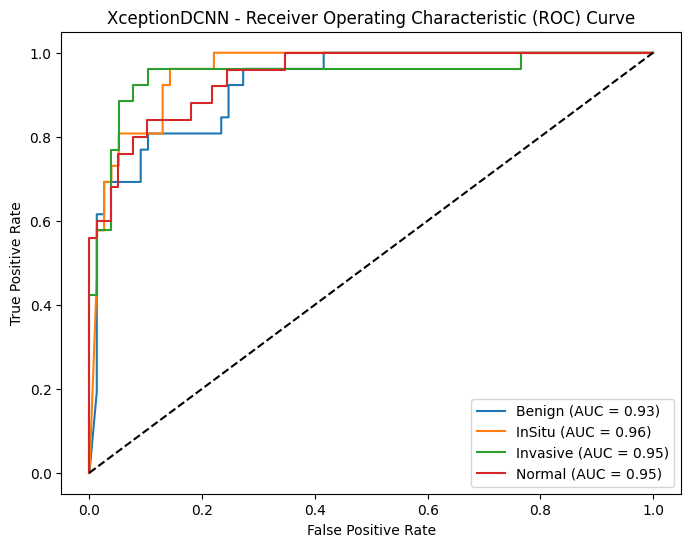

Benign: ROC AUC = 0.93
InSitu: ROC AUC = 0.96
Invasive: ROC AUC = 0.95
Normal: ROC AUC = 0.95


In [ ]:
from sklearn.metrics import roc_curve
def plot_roc_curve(y_true ,y_score, class_labels):


    # Compute false positive rate, true positive rate, and thresholds for each class
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()

    for i, label in enumerate(class_labels):
        fpr[label], tpr[label], thresholds[label] = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))

    for label in class_labels:
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('XceptionDCNN - Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/BACH-Results/XceptionDCNN/XceptionDCNN - ROC')
    plt.show()

    # Print ROC AUC for each class
    for label in class_labels:
        print(f'{label}: ROC AUC = {roc_auc[label]:.2f}')
plot_roc_curve(test_labels, preds , class_labels)

In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(true_labels , predicted_labels)

print(f'Kappa Value : {kappa}')

Kappa Value : 0.6628477905073651


In [ ]:
class_names = [model_name + '_' + label for label in class_labels]
class_names

['Xception_Benign', 'Xception_InSitu', 'Xception_Invasive', 'Xception_Normal']

In [ ]:
import pandas as pd
train_scores = model.predict(train_data)
val_scores = model.predict(validation_data)
test_scores = model.predict(test_data)

train_df = pd.DataFrame(train_scores, columns=class_names)
test_df = pd.DataFrame(test_scores, columns=class_names)
val_df = pd.DataFrame(val_scores, columns=class_names)

train_df['true_class'] = train_generator.labels
val_df['trues_class'] = val_generator.labels
test_df['true_class'] = test_generator.labels
# Save the dataframes to CSV files
train_df.to_csv('/content/drive/MyDrive/BACH-Results/train_combined.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/BACH-Results/test_combined.csv', index=False)
val_df.to_csv('/content/drive/MyDrive/BACH-Results/val_combined.csv', index=False)

4/4 [==============================] - 0s 3ms/step
